## <center> **A/B Testing on Advertisement Dataset.**</center>


The SmartAd company expects that the design of a new advertising distribution strategy can increase the success rate of ads from 45% to 50%. 

The new strategy involves providing creative and interactive online ads with the SmartAd brand, while the old strategy involves providing dummy ads.


### **Formulating Hypotheses**

#### **Null Hypothesis**

$$H_0: p = p_0$$ 

"There is no significant difference in the success rate of ads between the two groups."


#### **Alternative Hypothesis** 

$$H_a: p \ne p_0$$ 

"There is a significant difference in the success rate of ads between the two groups."


Given the uncertainty of whether the new design will perform *"better/worse/same"* as the current design, a two-tailed test will be conducted with a confidence Level of 95% i.e. (α = 0.05).

p and pₒ represent the conversion rate of the old design and the new design, with a confidence level of 95%.

$$\alpha = 0.05$$


### **1. Importing Libraries.**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.stats.api as sms
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [2]:
import requests
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

### **2. Data Preparation**

In [3]:
data_url = "https://raw.githubusercontent.com/Lulu-L2/MyDataset/main/AdSmartABdata%20-%20AdSmartABdata.csv"

response = requests.get(data_url)

In [4]:
with open("smart_ad_data.csv", "wb") as file:
    file.write(response.content)

In [5]:
df = pd.read_csv('smart_ad_data.csv',parse_dates=['date'])

In [6]:
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   auction_id   8077 non-null   object        
 1   experiment   8077 non-null   object        
 2   date         8077 non-null   datetime64[ns]
 3   hour         8077 non-null   int64         
 4   device_make  8077 non-null   object        
 5   platform_os  8077 non-null   int64         
 6   browser      8077 non-null   object        
 7   yes          8077 non-null   int64         
 8   no           8077 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 568.0+ KB


#### **Column Descriptions**

1. **auction_id**: Unique identifier for online users displayed on BIO. In standard terminology, this is referred to as the impression id. Users can view the BIO questionnaire but may choose not to respond. In this case, both the yes and no columns are set to zero.

2. **experiment**: The group to which the user belongs - control or exposed.
    * control: Users shown dummy ads.
    * exposed: Users shown online interactive ads with the SmartAd brand.
    
3. **date**: Date in the format YYYY-MM-DD.

4. **hour**: Hour of the day in the format HH.

5. **device_make**: Name of the type of device owned by the user, e.g., Samsung.

6. **platform_os**: OS id owned by the user.

7. **browser**: Name of the browser used by the user to view the BIO questionnaire.

8. **yes**: 1 if the user selected the "Yes" radio button for the BIO questionnaire.

9. **no**: 1 if the user selected the "No" radio button for the BIO questionnaire.

#### **Missing Null Values**

In [8]:
df.isnull().sum()

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

#### **Data Preprocessing**

Before proceeding and taking a data sample to obtain our subset, we will ensure that no users have been sampled multiple times.

In [9]:
session_counts = df['auction_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

In [10]:
print(f"There are {multi_users} users that appear two times or more in the dataset")

There are 0 users that appear two times or more in the dataset


#### **Removing non-answers from the dataframe.**

Non-answers (where the 'yes' and 'no' columns are both 0) represent users who did not fall into either category. 

While this may eliminate a significant percentage of observations, non-answers are not useful for our analysis since we cannot conclude whether the ad was successful or not. 

We will also consolidate the 'yes' and 'no' columns into a single column where "1 == ad_success" and "0 == ad_failure".

In [11]:
df['yes'].value_counts()

0    7505
1     572
Name: yes, dtype: int64

In [12]:
df['no'].value_counts()

0    7406
1     671
Name: no, dtype: int64

In [13]:
pd.crosstab(df['yes'],df['no'])

no,0,1
yes,,
0,6834,671
1,572,0


There are **"6834"** users who do not fall into either the 'yes' or 'no' category, and therefore, they will not contribute to the results of this study. 

Hence, it is necessary to remove the data of users who do not belong to either of these two categories.

In [14]:
df[['yes','no']]

,yes,no
0,0,0
1,0,0
2,0,1
3,0,0
4,0,0
...,...,...
8072,0,0
8073,0,0
8074,0,0
8075,0,0


In [15]:
if_ad_success = []

for x, y in zip(df.yes, df.no):
    if (x == 1) and (y == 0):
        if_ad_success.append(1)
    elif (x == 0) and (y == 1):
        if_ad_success.append(0)
    else:
        if_ad_success.append('no_response')

In [16]:
df['if_ad_success'] = if_ad_success

In [17]:
df = df.loc[~df.if_ad_success.isin(['no_response'])]
df = df.drop(['yes', 'no'], axis = 1)

#### **Exploring features : `device_make`, `browser` & `platform_os`.**

In [18]:
df['device_make'].value_counts()[:10]

Generic Smartphone    719
Samsung SM-G960F       45
Samsung SM-G950F       35
Samsung SM-G973F       22
Samsung SM-A202F       18
iPhone                 18
Samsung SM-G930F       16
Samsung SM-G975F       15
Samsung SM-A405FN      14
Samsung SM-A105FN      13
Name: device_make, dtype: int64

In [19]:
df['browser'].value_counts()

Chrome Mobile                 695
Chrome Mobile WebView         227
Facebook                      156
Samsung Internet              145
Mobile Safari                  14
Mobile Safari UI/WKWebView      3
Chrome                          2
Chrome Mobile iOS               1
Name: browser, dtype: int64

In [20]:
df["platform_os"].value_counts()

6    1226
5      17
Name: platform_os, dtype: int64

**Codifying the Device List.**

In [21]:
device_list_codified = []

for x in df.device_make:
    if 'Samsung' in x:
        device_list_codified.append(1)
    elif 'iPhone' in x:
        device_list_codified.append(2)
    else:
        device_list_codified.append(0)

**Codifying the Browser List.**

In [22]:
browser_list_codified = []

for x in df.browser:
    if 'Chrome' in x:
        browser_list_codified.append(1)
    elif 'Safari' in x:
        browser_list_codified.append(2)
    else:
        browser_list_codified.append(0)

In [23]:
df.device_make = device_list_codified
df.browser = browser_list_codified

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243 entries, 2 to 8071
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   auction_id     1243 non-null   object        
 1   experiment     1243 non-null   object        
 2   date           1243 non-null   datetime64[ns]
 3   hour           1243 non-null   int64         
 4   device_make    1243 non-null   int64         
 5   platform_os    1243 non-null   int64         
 6   browser        1243 non-null   int64         
 7   if_ad_success  1243 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 87.4+ KB


In [25]:
del if_ad_success, device_list_codified, browser_list_codified

df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,if_ad_success
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,0,6,1,0
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,0,6,1,1
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,0,6,1,0
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,1,6,0,1
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,0,6,1,0


### **3. Data Visualization**

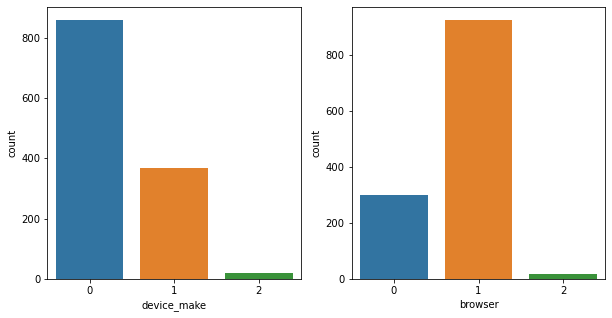

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

sns.countplot(x="device_make", data=df, ax=ax[0])
sns.countplot(x="browser", data=df, ax=ax[1])

plt.show()

**Checking the data distribution of the `device_make`, `browser`, and `platform_os` columns based on each experiment group.**

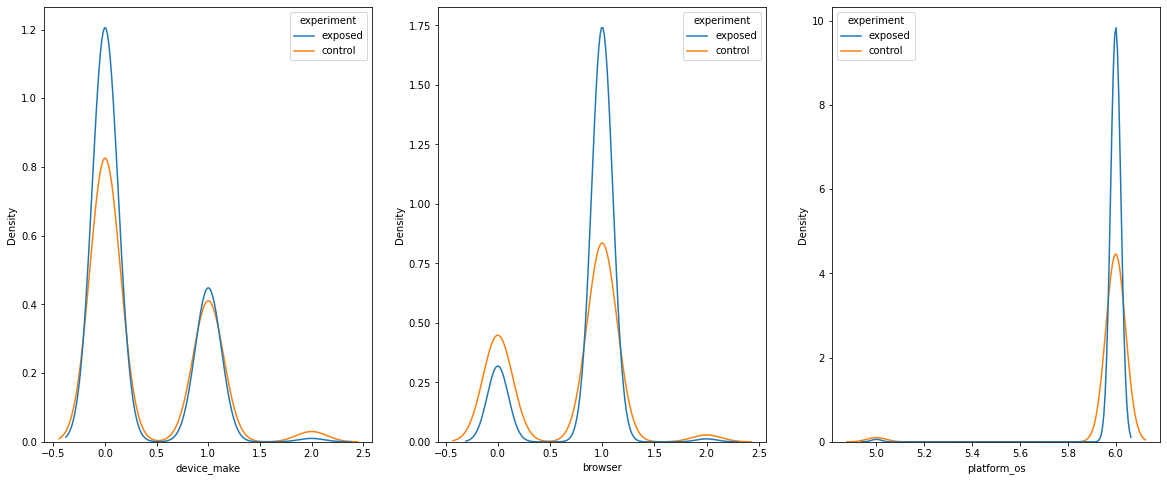

In [27]:
fig, ax = plt.subplots(1,3,figsize=(20,8))

sns.kdeplot(x='device_make', hue='experiment', data=df, ax=ax[0])
sns.kdeplot(x='browser', hue='experiment', data=df, ax=ax[1])
sns.kdeplot(x='platform_os', hue='experiment', data=df, ax=ax[2])

plt.show()

**Checking the remaining data count for each observation group.**

In [28]:
df['experiment'].value_counts()

exposed    657
control    586
Name: experiment, dtype: int64

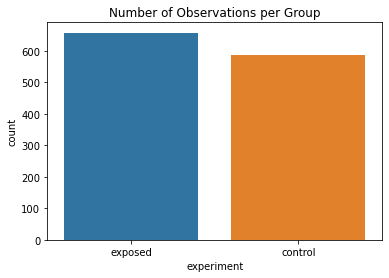

In [29]:
sns.countplot(x='experiment', data=df)
plt.title('Number of Observations per Group')
plt.show()

**Grouped Count of Ad Success by Experiment.**

In [30]:
df.groupby("experiment")["if_ad_success"]
df[["experiment", "if_ad_success"]]

,experiment,if_ad_success
2,exposed,0
16,exposed,1
20,exposed,0
23,control,1
27,control,0
...,...,...
8059,exposed,1
8063,exposed,1
8064,control,0
8069,control,0


**Group Data Segmentation :** Creating Control and Exposed Dataframes.

In [31]:
df_control = df[df.experiment =='control']
df_exposed = df[df.experiment =='exposed']

In [32]:
conversion_rates = df.groupby('experiment')['if_ad_success']

In [33]:
std_p = lambda x: np.std(x, ddof=0)   
std_err_p = lambda x: stats.sem(x, ddof=0)   

In [34]:
conversion_rates = conversion_rates.agg([np.mean, std_p, std_err_p])
conversion_rates.columns = ["success_rate", "std_deviation", "std_error"]

conversion_rates.style.format("{:.4f}")

,success_rate,std_deviation,std_error
experiment,,,
control,0.4505,0.4975,0.0206
exposed,0.4688,0.4990,0.0195


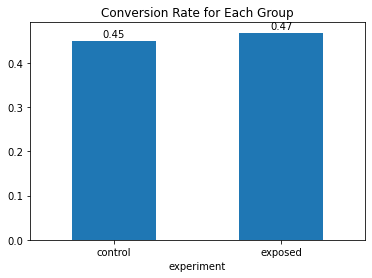

In [35]:
fig, ax = plt.subplots()

conversion_rates["success_rate"].plot.bar()

ax.bar_label(ax.containers[0], fmt="%.2f", label_type="edge", padding=2)
plt.title("Conversion Rate for Each Group")

plt.xticks(rotation=0)
plt.show()

### **Conclusion**

* The control and exposed groups accurately represent the population, as evidenced by the nearly identical distributions of `'device_make'`, `'browser'` and `'platform_os'` for both outcomes. 

* This is a positive sign, indicating that the division of the population between the control and exposed groups has been done in a way that both groups represent the total population.

* The success rate (conversion rate) of the control group aligns with expectations at 45%. However, the success rate of the exposed group is below the expected 50%, coming in at 47%. This falls short of the initial expectation.


### **4. Testing the hypothesis**


#### **Determining Sample Size.**

Since the company aims for an improvement from 45% to 50%, we can use this as the effect size to determine the sample size. 

The goal is to ensure that the selected sample adequately represents the population, with a power of 0.8, alpha of 0.05, and a ratio of 1.

In [36]:
effect_size = sms.proportion_effectsize(0.45, 0.50)
req_n = np.ceil(sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1))

**Print the required sample size and the total remaining samples in the dataset.**

In [37]:
print(f"Required data count for each group : {int(req_n)}")
print(f"Total data count in the dataset : {df.shape[0]}")

Required data count for each group : 1565
Total data count in the dataset : 1243


After removing non-answers from the dataframe, the total data count in the dataset is significantly below the required data count for each group. 

Despite the data shortage, hypothesis testing will still be conducted to determine whether there is a significant difference in the success rate of ads between the two groups or otherwise.

Testing the hypothesis involves calculating the **p-value**. 

- If the p-value is less than alpha=0.05, we cannot reject the null hypothesis. 

- OTOH, if the p-value is greater than 0.05, we can confidently reject the null hypothesis.


**Calculating the Success Rate for Each Group.**

In [38]:
ad_success_count = [df_control.if_ad_success.sum(), df_exposed.if_ad_success.sum()]

**Calculating the Data Count in Each Group.**

In [39]:
obsv_count = [df_control.if_ad_success.count(), df_exposed.if_ad_success.count()]

**Conducting Z-Test for Proportions.**

In [40]:
z_stat, p_val = proportions_ztest(ad_success_count, nobs=obsv_count)

**Calculating Using 95% Confidence Intervals.**

In [41]:
(l_ci_controlled, l_ci_exposed), (u_ci_controlled, u_ci_exposed) = proportion_confint(ad_success_count, nobs=obsv_count, alpha=0.05)

In [42]:
print(f'z-statistic : {z_stat:.2f}')
print('p-value : {}'.format(p_val.round(4)))

z-statistic : -0.65
p-value : 0.5185


In [43]:
print(f"95% CI Value for the Controlled Group: [{l_ci_controlled.round(4)}, {u_ci_controlled.round(4)}]")
print(f"95% CI Value for the Exposed Group: [{l_ci_exposed.round(4)}, {u_ci_exposed.round(4)}]")

95% CI Value for the Controlled Group: [0.4102, 0.4908]
95% CI Value for the Exposed Group: [0.4306, 0.507]


### **5. Conclusion**

* The obtained p-value for 'ad_success' (0.5185) is significantly above the specified threshold (confidence level 95%, alpha = 0.05), and therefore, *****we cannot reject the 'Null Hypothesis' (Hₒ: p = pₒ), which states that there is no significant difference between the two groups.*****

* After removing non-answers *(both 'yes' and 'no' columns == 0)* from the dataset, the remaining data count is only 1243 (losing **6834** data observations or **84.61%** of the initial dataset). The substantial loss of data leads to a lack of observations to ensure the detection of significant differences.

* The target to increase the ad success rate to 50% has not been achieved using the new design strategy.

* These findings suggest that there is no strong business justification to advocate for the implementation of the new ad design over the old one, as it will not yield additional benefits.